# Data-driven Channel Precoding

A ML model should be capable of learning the channel behavior of arbitrary transmission channels, especially given non-linear function implementation. Parts of this project:
* Create a channel
* Baseline evaluation
* ML model precoding

In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import sys,os,time,datetime,warnings,math,itertools

import torch
import pandas as pd

import tqdm

## Helper functions used
1) Uses the time-invariant MIMO channel available under the helper functions section

2) Uses the simple channel inversion precoder as a baseline model, also available as helper function 

In [ ]:
sys.path.append('../../7_HELPERFUNCTIONS/')
from WorldSimulators.TransferChannels import MIMOTimeInvariant
from Precoders.SimplePrecoders import ChannelInversionPrecoder

## Simple transfer channel as channel
A simple random n $\times$ m transfer channel with transmit matrix $\mathbf{H}$, no other disturbances.

In [79]:
channel = MIMOTimeInvariant(90,100)

## Baseline Precoder
Simple channel inversion precoder to estimate $\mathbf{H}$ by estimating $\mathbf{H}^{-1}$.

In [80]:
precoder = ChannelInversionPrecoder(channel)
avg_err,C,_ = precoder.random_tests(num_tests=15)

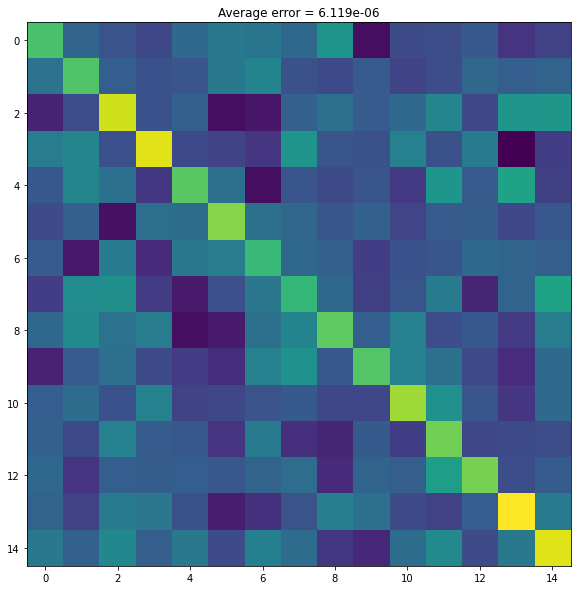

In [81]:
fig = plt.figure(figsize=(10,10))

plt.imshow(C)
plt.title('Average error = {0:.4}'.format(avg_err))

plt.show()

### Evaluation of simple precoder
Dealing with a 90 $\times$ 100 channel, i.e. 90 RX antennas and 100 TX antennas, and 15 randomly chosen test vectors, the transmitted symbols strongly correlate with the intended symbols. Total error is on average around the micro-range.

## ML Precoder
Compare the above result to a data-driven precoder which learns the channel.

In [51]:
class MLPrecoder(torch.nn.Module):
    def __init__(self,channel):
        super(MLPrecoder,self).__init__()
        self.l0 = torch.nn.Linear(channel.out_size,16)
        self.l1 = torch.nn.Linear(16,channel.in_size)
    def forward(self,x):
        x = torch.nn.functional.relu(self.l0(x))
        x = self.l1(x)
        return x

In [87]:
precoder = MLPrecoder(channel) 

In [90]:
target = rnd.randn(channel.out_size)
precoded = precoder(torch.from_numpy(target).float().reshape(-1))

received = channel.transfer_v(precoded.detach().numpy())

c_err = np.linalg.norm(target-received,2)

In [429]:
#optimizer = torch.optim.Adam(precoder.parameters(),lr=0.01)
#criterion = torch.nn.MSELoss()

num_epochs = 5
val_size = 0.2

batch_size = 1

epsilon = 0.1

In [430]:
R = []

y_target = torch.tensor(rnd.randn(n)).float()

for k in range(1000):

    if (k+1)%100==0: print('Run {}'.format(k+1))
    
    
    x_hat = precoder(y_target)
    
    if torch.isnan(x_hat).any(): break
    
    y_measured = channel.transfer_v(np.array(x_hat.tolist()))

    penalty = np.linalg.norm(np.array(y_target)-y_measured,axis=1)
    
    c_grad = torch.autograd.grad(x_hat.sum().log(),precoder.parameters())
    for layer,p in enumerate(precoder.parameters()):
        p.data += c_grad[layer]*epsilon*penalty[0]

    R.append(penalty)

Run 100
Run 200
Run 300
Run 400
Run 500
Run 600
Run 700
Run 800
Run 900
Run 1000


In [431]:
R

[array([4.09842089]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.61922726]),
 array([5.

In [432]:
y_target

tensor([-2.1669,  0.7192, -1.1355,  1.0028, -0.5816])

In [433]:
y_measured

array([[1.89430367, 1.1793932 , 1.52419856, 0.99367888, 2.21066926]])

In [422]:
np.linalg.norm((np.array(y_target)-y_measured)[0])

6.459812584828123

In [424]:
penalty[0]

6.459812584828123